# Analyse the different train/test period experiments

In [8]:
# !pip install netcdf4

In [9]:
# !conda install -c conda-forge shap==0.30 --yes

In [10]:
# !conda update matplotlib

In [11]:
from pathlib import Path
import os
import warnings
from typing import Tuple, Optional, Union, Dict, List

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [13]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

# load in ALL data for comparison

In [14]:
TRUE_EXPERIMENT = 'one_month_forecast_boku_VCI'
TARGET_VAR =      'boku_VCI'
EXPERIMENT =      'one_month_forecast_boku_VCI'

In [15]:
ds = xr.open_dataset(data_dir / 'tommy/ds.nc')
static_ds = xr.open_dataset(data_dir / 'tommy/static_ds.nc')
X_train = xr.open_dataset(data_dir / 'tommy/X_train.nc')
y_train = xr.open_dataset(data_dir / 'tommy/y_train.nc')
X_test = xr.open_dataset(data_dir / 'tommy/X_test.nc')
y_test = xr.open_dataset(data_dir / 'tommy/y_test.nc')

In [16]:
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 ...
    VCI3M       (time, lat, lon) float64 ...
    modis_ndvi  (time, lat, lon) float64 ...
    VCI         (time, lat, lon) float64 ...
    precip      (time, lat, lon) float64 ...
    E           (time, lat, lon) float64 ...
    Eb          (time, lat, lon) float64 ...
    SMroot      (time, lat, lon) float64 ...
    SMsurf      (time, lat, lon) float64 ...
    p84.162     (time, lat, lon) float64 ...
    pev         (time, lat, lon) float64 ...
    sp          (time, lat, lon) float64 ...
    t2m         (time, lat, lon) float64 ...
    tp          (time, lat, lon) float64 ...

# Get all experiment files

In [17]:
EXPERIMENT_NAME = 'robustness_boku_VCI'
features = [d for d in (data_dir / 'features' / EXPERIMENT_NAME).glob('2020*TR*')]
features.sort()
model_dirs = [d for d in (data_dir / 'models' / EXPERIMENT_NAME).glob('2020*TR*')]
model_dirs.sort()

print(f"No. Driving Data:  {len(features)}")
print(f"No. Modelled Data: {len(model_dirs)}")

print(features[0])
print(model_dirs[0])

No. Driving Data:  27
No. Modelled Data: 27
data/features/robustness_boku_VCI/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51
data/models/robustness_boku_VCI/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51


In [18]:
# get parameters for experiments
test_length = 12
pred_timesteps = 3

train_hilos = [m.name.split('_')[-3][2:] for m in model_dirs]
test_hilos = [m.name.split('_')[-2][2:] for m in model_dirs]
train_lengths = [int(m.name.split('_')[-1][3:]) for m in model_dirs]

In [19]:
from pandas.tseries.offsets import MonthEnd

# GET TEST TIMES
test_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('preds_')[-1].replace('.nc', '').split('_'))) + MonthEnd(1)
        for d in (model / 'ealstm').glob('*.nc')
    ])
    for model in model_dirs
]

test_times2 = [
    np.array([
        pd.to_datetime('-'.join(dir_.name.split('_'))) + MonthEnd(1)
        for dir_ in (feature / 'test').iterdir() if dir_.name != 'ERROR'
    ])
    for feature in features
]

# GET TRAIN TIMES
train_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('_'))) + MonthEnd(1)
        for d in (feature / 'train').iterdir()
    ])
    for feature in features
]

# check no. test timesteps is 
# assert all([test_length == len(tt) for tt in test_times2])

# check no. train timesteps are equivalent
assert all([np.isclose(train_lengths[i], len(train_times[i]), atol=15) for i in range(len(train_times))])

print(train_lengths)
print([len(train_times[i]) for i in range(len(train_times))])

# TODO: why is the number of model preds.nc objects different?
print([len(test_times[i]) for i in range(len(test_times))])
print([len(test_times2[i]) for i in range(len(test_times2))])

[51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153]
[51, 114, 154, 51, 114, 154, 51, 113, 153, 51, 114, 153, 51, 113, 154, 51, 110, 154, 51, 115, 155, 51, 112, 153, 51, 114, 156]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


## Rebuild experiment objects

In [20]:
from scripts.experiments.experiment import Experiment

In [21]:
sorted_timesteps = pd.date_range('2002-01-01', '2019-01-01', freq='M')
all_experiments = {}
for (
    train_hilo, test_hilo, train_timesteps, test_timesteps, train_length
) in zip(train_hilos, test_hilos, train_times, test_times2, train_lengths):
    
    expt_name = f"one_month_forecast_TR{train_hilo}_TE{test_hilo}_LEN{train_length}"
    e = Experiment(
        train_length=train_length,
        train_hilo=train_hilo,
        test_hilo=test_hilo,
        test_length=12,
        sorted_timesteps=sorted_timesteps,
        pred_timesteps = 3,
    )
    e.train_timesteps = train_timesteps
    e.test_timesteps = test_timesteps
    
    all_experiments[expt_name] = e

one_month_forecast_TRmed_TEhigh_LEN153


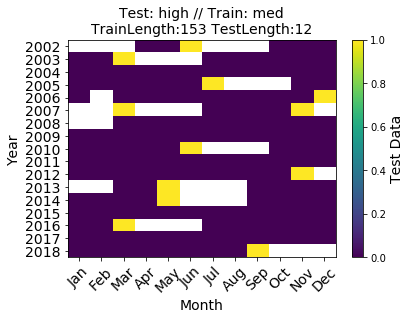

In [22]:
experiment = [k for k in all_experiments.keys()][11]
print(experiment)
# print(dir(all_experiments['one_month_forecast_TRhigh_TEhigh_LEN51']))

fig, ax = plt.subplots()
all_experiments[experiment].plot_experiment_split(ax=ax)
# all_experiments[experiment].test_timesteps

# Load in the data

In [39]:
# Experiment names
experiments = [d.name for d in model_dirs]
true_data_experiments = [d.name for d in features]
true_data_paths = [f"{f.parents[0].name}/{f.name}" for f in features]
experiment_paths = [f"{f.parents[0].name}/{f.name}" for f in model_dirs]

TARGET_VAR = 'boku_VCI'

# check the experiments are aligned properly
assert all(
    [
        '_'.join(experiments[i].split('_')[3:]) == '_'.join(true_data_experiments[i].split('_')[3:])
        for i in range(len(experiments))
    ]
)

In [31]:
print('_'.join(experiments[0].split('_')[3:]))
print('_'.join(true_data_experiments[0].split('_')[3:]))

one_month_forecast_TRhigh_TEhigh_LEN51
one_month_forecast_TRhigh_TEhigh_LEN51


In [36]:
from src.utils import get_ds_mask

X_train, _ = read_train_data(data_dir, experiment=true_data_paths[0])
mask = get_ds_mask(X_train.VCI)

In [52]:
import pickle

# ONLY RUN IF DATA NOT SAVED!
if (data_dir / 'tommy/obs_dict.pkl').exists() and (data_dir / 'tommy/model_dict.pkl').exists():
    obs_dict = pickle.load(open(data_dir / 'tommy/obs_dict.pkl', 'rb'))
    model_dict = pickle.load(open(data_dir / 'tommy/model_dict.pkl', 'rb'))
else:
    obs_dict = {}
    model_dict = {}

    for TRUE_EXPERIMENT, EXPERIMENT in zip(true_data_paths, experiment_paths):
        expt_name = '_'.join(EXPERIMENT.split('_')[3:])
        obs_dict[expt_name] = {}
        model_dict[expt_name] = {}

        # get the observed X, y data
        X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
        X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)

        obs_dict[expt_name]['X_train'] = X_train
        obs_dict[expt_name]['y_train'] = y_train
        obs_dict[expt_name]['X_test'] = X_test
        obs_dict[expt_name]['y_test'] = y_test

        # Get the model predictions
        lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

        model_dict[expt_name]['lstm_pred'] = lstm_pred
        model_dict[expt_name]['bline_pred'] = bline_pred
        model_dict[expt_name]['ealstm_pred'] = ealstm_pred

    
    print(f'Saving to {data_dir / "tommy"}')
    with open(data_dir / 'tommy/obs_dict.pkl', 'wb') as fp:
        pickle.dump(obs_dict, fp)
    with open(data_dir / 'tommy/model_dict.pkl', 'wb') as fp:
        pickle.dump(model_dict, fp)

print('** DONE! **')

** DONE! **


In [48]:
all_experiments.keys()

dict_keys(['one_month_forecast_TRhigh_TEhigh_LEN51', 'one_month_forecast_TRhigh_TEhigh_LEN102', 'one_month_forecast_TRhigh_TEhigh_LEN153', 'one_month_forecast_TRhigh_TEmed_LEN51', 'one_month_forecast_TRhigh_TEmed_LEN102', 'one_month_forecast_TRhigh_TEmed_LEN153', 'one_month_forecast_TRhigh_TElow_LEN51', 'one_month_forecast_TRhigh_TElow_LEN102', 'one_month_forecast_TRhigh_TElow_LEN153', 'one_month_forecast_TRmed_TEhigh_LEN51', 'one_month_forecast_TRmed_TEhigh_LEN102', 'one_month_forecast_TRmed_TEhigh_LEN153', 'one_month_forecast_TRmed_TEmed_LEN51', 'one_month_forecast_TRmed_TEmed_LEN102', 'one_month_forecast_TRmed_TEmed_LEN153', 'one_month_forecast_TRmed_TElow_LEN51', 'one_month_forecast_TRmed_TElow_LEN102', 'one_month_forecast_TRmed_TElow_LEN153', 'one_month_forecast_TRlow_TEhigh_LEN51', 'one_month_forecast_TRlow_TEhigh_LEN102', 'one_month_forecast_TRlow_TEhigh_LEN153', 'one_month_forecast_TRlow_TEmed_LEN51', 'one_month_forecast_TRlow_TEmed_LEN102', 'one_month_forecast_TRlow_TEmed_LEN1

In [63]:
# remove the timestamp from experiment name
if ':' in [k for k in model_dict.keys()][0]:
    model_dict = {'_'.join(k.split(':')[-1].split('_')[1:]): v for k, v in model_dict.items()}

if ':' in [k for k in obs_dict.keys()][0]:
    obs_dict = {'_'.join(k.split(':')[-1].split('_')[1:]): v for k, v in obs_dict.items()}

model_dict.keys()

dict_keys(['one_month_forecast_TRhigh_TEhigh_LEN51', 'one_month_forecast_TRhigh_TEhigh_LEN102', 'one_month_forecast_TRhigh_TEhigh_LEN153', 'one_month_forecast_TRhigh_TEmed_LEN51', 'one_month_forecast_TRhigh_TEmed_LEN102', 'one_month_forecast_TRhigh_TEmed_LEN153', 'one_month_forecast_TRhigh_TElow_LEN51', 'one_month_forecast_TRhigh_TElow_LEN102', 'one_month_forecast_TRhigh_TElow_LEN153', 'one_month_forecast_TRmed_TEhigh_LEN51', 'one_month_forecast_TRmed_TEhigh_LEN102', 'one_month_forecast_TRmed_TEhigh_LEN153', 'one_month_forecast_TRmed_TEmed_LEN51', 'one_month_forecast_TRmed_TEmed_LEN102', 'one_month_forecast_TRmed_TEmed_LEN153', 'one_month_forecast_TRmed_TElow_LEN51', 'one_month_forecast_TRmed_TElow_LEN102', 'one_month_forecast_TRmed_TElow_LEN153', 'one_month_forecast_TRlow_TEhigh_LEN51', 'one_month_forecast_TRlow_TEhigh_LEN102', 'one_month_forecast_TRlow_TEhigh_LEN153', 'one_month_forecast_TRlow_TEmed_LEN51', 'one_month_forecast_TRlow_TEmed_LEN102', 'one_month_forecast_TRlow_TEmed_LEN1

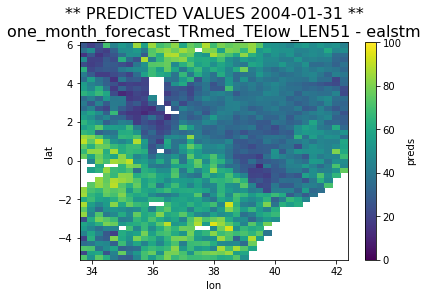

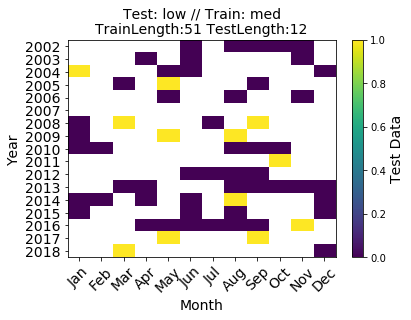

In [56]:
fig, ax = plt.subplots()
time_ix = 1
kwargs = dict(vmin=0, vmax=100, cmap='viridis')

experiment_name = [k for k in model_dict.keys()][-12]
time = model_dict[experiment_name]['ealstm_pred'].time.values
model_dict[experiment_name]['ealstm_pred'].isel(time=time_ix).plot(ax=ax, **kwargs)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0][2:]} **\n{experiment_name} - ealstm", size=16);

all_experiments[experiment_name].plot_experiment_split()

## Clean up the missing/extra preds (TODO: WHY?)

**NOTE**: This code is unnecessary. Sorry past me for making you write this ...

In [57]:
print([len(test_times[i]) for i in range(len(test_times))])
print([len(test_times2[i]) for i in range(len(test_times2))])

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


In [58]:
print([len(test_times[i]) for i in range(len(test_times))])
print([len(test_times2[i]) for i in range(len(test_times2))])

if False:
    # which datetimes are missing / extra?
    # GET TEST TIMES
    model_test_dirs = [
        np.array([
            d.name.split('preds_')[-1].replace('.nc', '')
            for d in (model / 'ealstm').glob('*.nc')
        ])
        for model in model_dirs
    ]

    obs_test_dirs = [
        np.array([
            d.name
            for d in (feature / 'test').iterdir()
        ])
        for feature in features
    ]
    # sort the files
    [a.sort() for a in model_test_dirs]
    [a.sort() for a in obs_test_dirs]

    # WHICH EXPERIMENTS HAVE ISSUES WITH NUMBER OF PREDS?
    bool_have_issue = [len(model_test_dirs[i]) != len(obs_test_dirs[i]) for i in range(len(model_test_dirs))]
    model_dirs_with_issues = np.array(model_dirs)[bool_have_issue]
    obs_dirs_with_issues = np.array(features)[bool_have_issue]

    # create a dictionary of EXPERIMENT NAME -> valid preds (obs)
    expts_with_issues = [d.name for d in model_dirs_with_issues]
    valid_obs_test_timesteps = [[d.name for d in list(dir_.glob('test/*'))] for dir_ in obs_dirs_with_issues]
    model_valid_timesteps_lookup = dict(zip(expts_with_issues, valid_obs_test_timesteps))

    expts_with_issues = [d.name for d in model_dirs_with_issues]
    valid_model_test_timesteps = [
        np.unique(
            [d.name.split('preds_')[-1].replace('.nc', '') for d in list(dir_.glob('**/**/*.nc'))]
        ) 
        for dir_ in model_dirs_with_issues
    ]
    obs_valid_timesteps_lookup = dict(zip(expts_with_issues, valid_model_test_timesteps))

    # Two possibilities:
    # a) too many preds in the model dirs (in model but not obs)
    # b) too few preds in the model dirs (in obs but not model)

    ## -------- MODELS -------- ##
    # Create a dataframe (easier to visualise/work with)
    a = [list(parent_d.glob('**/*.nc')) for parent_d in model_dirs_with_issues]
    all_array = np.array([])
    all_array = np.append(all_array, a[0])
    all_array = np.append(all_array, a[1])
    all_array = np.append(all_array, a[2])
    model_names = [d.parents[0].name for d in all_array]
    experiment_names = [d.parents[1].name for d in all_array]
    all_times = [d.name.split('preds_')[-1].replace('.nc', '') for d in all_array]

    model_dirs_df = pd.DataFrame({
        'experiment': experiment_names,
        'model': model_names,
        'path': all_array,
        'time': all_times,
    })
    model_dirs_df['is_valid'] = model_dirs_df.apply(lambda row: row.time in model_valid_timesteps_lookup[row.experiment], axis=1)


    ## -------- OBSERVATIONS -------- ##
    obs_dirs_with_issues = np.array(features)[bool_have_issue]
    a = [list(parent_d.glob('test/*')) for parent_d in obs_dirs_with_issues]
    all_array = np.array([])
    all_array = np.append(all_array, a[0])
    all_array = np.append(all_array, a[1])
    all_array = np.append(all_array, a[2])
    experiment_names = [d.parents[1].name for d in all_array]
    all_times = [d.name for d in all_array]
    obs_dirs_df = pd.DataFrame({
        'experiment': experiment_names,
        'path': all_array,
        'time': all_times,
    })
    obs_dirs_df['is_valid'] = obs_dirs_df.apply(lambda row: row.time in obs_valid_timesteps_lookup[row.experiment], axis=1)

    display(model_dirs_df.head())
    display(obs_dirs_df.head())

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


In [59]:
## NOTE: This code is completely unneecessary! We can match timesteps later on instead
# of messing around with moving files around ...

import shutil


def move_model_path(file_path: Path) -> None:
    error_dir = (file_path.parents[0] / 'ERROR')
    # MAKE Error Direcory
    if not error_dir.exists():
        error_dir.mkdir(exist_ok=True, parents=False)

    # DEFINE the to path
    to_path = error_dir / file_path.name
    # MOVE the file
    shutil.move((file_path).as_posix(), (to_path).as_posix())
    print(f"Moved: {file_path} to {to_path}")


if False:
    ### Move the invalid paths to a new location
    models_to_move = model_dirs_df.loc[~model_dirs_df.is_valid]
    obs_to_move = obs_dirs_df.loc[~obs_dirs_df.is_valid]

    for file_path in models_to_move.path:
        move_model_path(file_path)

    for file_path in obs_to_move.path:
        move_model_path(file_path)


# Model Performance Scores

### Pixel wise performance

In [60]:
# how many preds in each 
[d for d in model_dirs[0].iterdir()]

print([len(a) for a in test_times])
print([len(a) for a in test_times2])

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


In [64]:
from src.analysis import spatial_rmse, spatial_r2

rmse_dict = {}
r2_dict = {}
mean_performances = {}

for experiment_name in [k for k in model_dict.keys()]:
    print(experiment_name)
    rmse_dict[experiment_name] = {}
    r2_dict[experiment_name] = {}
    
    # iterate over each model defined for that experiment
    models = [k for k in model_dict[experiment_name].keys()]
    
    for model in models:
        obs = obs_dict[experiment_name]['y_test'][TARGET_VAR].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"])
        preds = model_dict[experiment_name][model].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"])
        
        # ONLY SELECT MATCHING TIMES (Why are there errors here anyway?)
        preds = preds.sel(time=np.isin(preds.time, obs.time))
        obs = obs.sel(time=np.isin(obs.time, preds.time))

        # ------- RMSE -------
        model_rmse = spatial_rmse(
            obs, preds
        )
        rmse_dict[experiment_name][model] = model_rmse
        
        # ------- R2 -------
        model_r2 = spatial_r2(
            obs, preds
        )
        r2_dict[experiment_name][model] = model_r2

        # calculate mean performance scores
        model_mean_rmse = model_rmse.mean().values
#         print(f"{experiment_name} {model} mean RMSE: ".ljust(20), f"{model_mean:.2f}")
        model_mean_r2 = model_r2.mean().values
#         print(f"{experiment_name} {model} mean R2: ".ljust(20), f"{model_mean:.2f}")
        
        # build mean performance dictionaries
        mean_performances[experiment_name] = {}
        mean_performances[experiment_name][model] = {}
        mean_performances[experiment_name][model]['rmse'] = model_mean_rmse
        mean_performances[experiment_name][model]['r2'] = model_mean_r2

one_month_forecast_TRhigh_TEhigh_LEN51
one_month_forecast_TRhigh_TEhigh_LEN102
one_month_forecast_TRhigh_TEhigh_LEN153
one_month_forecast_TRhigh_TEmed_LEN51
one_month_forecast_TRhigh_TEmed_LEN102
one_month_forecast_TRhigh_TEmed_LEN153
one_month_forecast_TRhigh_TElow_LEN51
one_month_forecast_TRhigh_TElow_LEN102
one_month_forecast_TRhigh_TElow_LEN153
one_month_forecast_TRmed_TEhigh_LEN51
one_month_forecast_TRmed_TEhigh_LEN102
one_month_forecast_TRmed_TEhigh_LEN153
one_month_forecast_TRmed_TEmed_LEN51
one_month_forecast_TRmed_TEmed_LEN102
one_month_forecast_TRmed_TEmed_LEN153
one_month_forecast_TRmed_TElow_LEN51
one_month_forecast_TRmed_TElow_LEN102
one_month_forecast_TRmed_TElow_LEN153
one_month_forecast_TRlow_TEhigh_LEN51
one_month_forecast_TRlow_TEhigh_LEN102
one_month_forecast_TRlow_TEhigh_LEN153
one_month_forecast_TRlow_TEmed_LEN51
one_month_forecast_TRlow_TEmed_LEN102
one_month_forecast_TRlow_TEmed_LEN153
one_month_forecast_TRlow_TElow_LEN51
one_month_forecast_TRlow_TElow_LEN102
one

### Build DataFrame for plotting

In [65]:
def dict_to_arrays(dict_object) -> Tuple[List[str], List[str], List[xr.Dataset]]:
    """
    Convert the dictionaries calculated above into lists for 
    the creation of a pandas.DataFrame
    
    Dict should be in format
    {'experiment_name' : { 'model_name': xr.Dataset } }
    """
    experiments = [e for e in dict_object.keys()]
    models_list = np.array(
        [
            [m for m in dict_object[expt].keys()] 
            for expt in [e for e in dict_object.keys()]
        ]
    ).flatten()
    models = np.unique(models_list)
    experiments_list = np.array(experiments).repeat(len(models))

    values = []
    for model, experiment in zip(models_list, experiments_list):
        values.append(dict_object[experiment][model])

    assert len(models_list) == len(experiments_list)
    assert len(values) == len(models_list)
    
    return models_list, experiments_list, values


# experiments = [e for e in rmse_dict.keys()]
# models_list = np.array([[m for m in rmse_dict[expt].keys()] for expt in [e for e in rmse_dict.keys()]]).flatten()
# models = np.unique(models_list)
# experiments_list = np.array(experiments).repeat(3)

# all_rmses = []
# for model, experiment in zip(models_list, experiments_list):
#     all_rmses.append(rmse_dict[experiment][model])
    

models_list, experiments_list, all_rmses = dict_to_arrays(rmse_dict)
rmse_means = [rmse.compute().mean().values for rmse in all_rmses]

models_list, experiments_list, all_r2s = dict_to_arrays(r2_dict)
r2_means = [r2.compute().mean().values for r2 in all_r2s]

In [66]:
[m for m in experiments_list][:5]

['one_month_forecast_TRhigh_TEhigh_LEN51',
 'one_month_forecast_TRhigh_TEhigh_LEN51',
 'one_month_forecast_TRhigh_TEhigh_LEN51',
 'one_month_forecast_TRhigh_TEhigh_LEN102',
 'one_month_forecast_TRhigh_TEhigh_LEN102']

In [67]:
def create_experiment_dataframe(
    experiments_list: List[str], 
    models_list: List[str], 
    values: List[float],
    col_name: str = 'RMSE',
) -> pd.DataFrame:
    train_hilos = [m.split('_')[-3][2:] for m in experiments_list]
    test_hilos = [m.split('_')[-2][2:] for m in experiments_list]
    train_lengths = [int(m.split('_')[-1][3:]) for m in experiments_list]

    values_df = pd.DataFrame({
        'experiment': experiments_list,
        'model': models_list,
        'test_hilo': test_hilos,
        'train_hilo': train_hilos,
        'train_length': train_lengths,
        col_name: values,
    })
    return values_df.astype({col_name: float, 'train_length': int})

# 
mean_rmse_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=rmse_means
)

display(mean_rmse_df.head())

# 
mean_r2_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=r2_means,
    col_name='R2'
)
display(mean_r2_df.head())

,experiment,model,test_hilo,train_hilo,train_length,RMSE
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,21.431805
1,one_month_forecast_TRhigh_TEhigh_LEN51,bline_pred,high,high,51,25.865590
2,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,20.413579
3,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,18.856507
4,one_month_forecast_TRhigh_TEhigh_LEN102,bline_pred,high,high,102,24.182788


,experiment,model,test_hilo,train_hilo,train_length,R2
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,0.426466
1,one_month_forecast_TRhigh_TEhigh_LEN51,bline_pred,high,high,51,0.121839
2,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,0.466974
3,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,0.523342
4,one_month_forecast_TRhigh_TEhigh_LEN102,bline_pred,high,high,102,0.195182


In [68]:
# mean_rmse_df.model == 'ealstm_pred'
(
    mean_rmse_df.set_index(['test_hilo', 'train_hilo', 'train_length'])
    .query('model == "ealstm_pred"')
    .RMSE
).head()

test_hilo  train_hilo  train_length
high       high        51              20.413579
                       102             19.531255
                       153             18.696899
med        high        51              19.827745
                       102             19.953286
Name: RMSE, dtype: float64

In [69]:
train_lengths = [51, 102, 153]
train_length = train_lengths[0]
# display(
#     mean_rmse_df
#     .query(f'model == "ealstm_pred" & train_length == {train_length}')
#     .drop(columns=['experiment', 'model', 'train_length'])
#     .set_index(['test_hilo', 'train_hilo'])
# )
# display(
#     mean_rmse_df
#     .query(f'model == "bline_pred" & train_length == {train_length}')
#     .drop(columns=['experiment', 'model', 'train_length'])
#     .set_index(['test_hilo', 'train_hilo'])
# )
# display(
#     mean_rmse_df
#     .query(f'model == "ealstm_pred" & train_length == {train_length}')
#     .drop(columns=['experiment', 'model', 'train_length'])
#     .set_index(['test_hilo', 'train_hilo'])
#     .values.reshape(3,3)
# )

# Experiment Parameters
- **Train Length** = short, medium, long
- **Test VCI** = low, medium, high
- **Train VCI** = low, medium, high

#### Hypotheses
* The model performance will improve as the train length gets longer (more data)
* The model will perform better when it is trained on a similar regime to the testing regime (high-high, low-low [TR:TE])
* The model performance will change gradually (better for medium-low than high-low [TR:TE])

# Plot Experiment Matrices (RMSE)

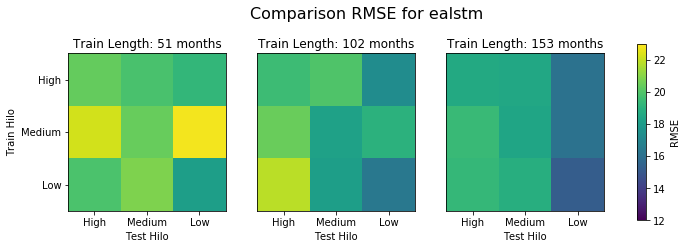

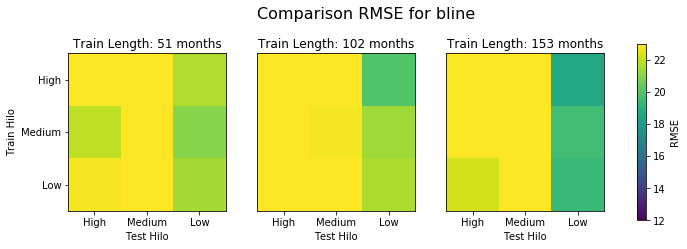

In [70]:
# plot matrices
model = 'ealstm'
kwargs = dict(vmin=12, vmax=23)
value_df = mean_rmse_df

def plot_experiment_matrices(value_df: pd.DataFrame, model: str, value: str = 'RMSE', **kwargs):
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    train_lengths = [51, 102, 153]  # df.train_length.unique()

    for ix, train_length in enumerate(train_lengths):
        ax_ix = np.unravel_index(ix, (3,))
        ax = axs[ax_ix]
        im = ax.imshow(
            value_df
            .query(f'model == "{model}_pred" & train_length == {train_length}')
            .drop(columns=['experiment', 'model', 'train_length'])
            .set_index(['test_hilo', 'train_hilo'])
            .values.reshape(3,3),
            **kwargs
        )

        ax.set_title(f'Train Length: {train_length} months')
        ax.set_xlabel('Test Hilo')
        ax.set_xticks(np.arange(0, 3))
        ax.set_xticklabels(['High', 'Medium', 'Low'])

        if ax_ix == (0, ):
            ax.set_ylabel('Train Hilo')
            ax.set_yticks(np.arange(0, 3))
            ax.set_yticklabels(['High', 'Medium', 'Low'])
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.set_yticklabels([])

    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.65)
    cbar.set_label(value)
    fig.suptitle(f'Comparison {value} for {model}', y=0.85, x=0.47, fontsize=16);
    

plot_experiment_matrices(value_df, model, value='RMSE', **kwargs)
plot_experiment_matrices(value_df, model='bline', value='RMSE', **kwargs)

* It looks like the LOWER test periods are MORE PERSISTENT (so poor vegetation conditions follow on from other poor vegetation conditions)
* This means that this is inherently easier to predict (?)
* We need to compare our results to 

NOTE: the cmap is different for the baseline to actually view the differences


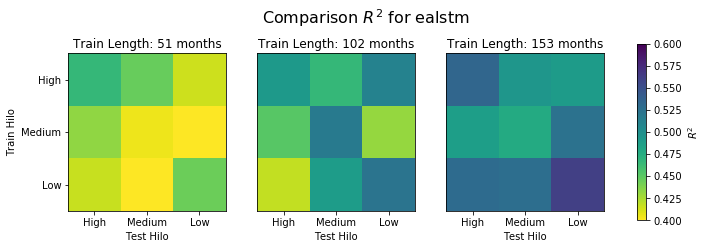

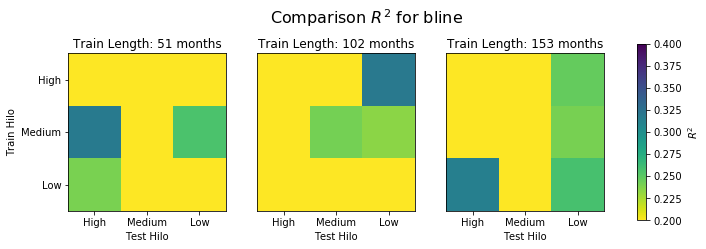

In [71]:
# plot matrices
model = 'ealstm'
kwargs = dict(vmin=0.4, vmax=0.6, cmap='viridis_r')
plot_experiment_matrices(mean_r2_df, model, value='$R^2$', **kwargs)

print("NOTE: the cmap is different for the baseline to actually view the differences")
kwargs = dict(vmin=0.2, vmax=0.4, cmap='viridis_r')
plot_experiment_matrices(mean_r2_df, model='bline', value='$R^2$', **kwargs)

### calculate the difference from Persistence

In [72]:
# experiment = experiments[0]
diff_rmse_dict = {}
diff_r2_dict = {}

for experiment in [k for k in rmse_dict.keys()]:
    diff_rmse_dict[experiment] = {}
    diff_r2_dict[experiment] = {}

    for model in [k for k in rmse_dict[experiment].keys() if k != "bline_pred"]:
        model_rmse_diff = rmse_dict[experiment]['bline_pred'] - rmse_dict[experiment][model]
        model_r2_diff = r2_dict[experiment][model] - r2_dict[experiment]['bline_pred']

        diff_rmse_dict[experiment][model] = model_rmse_diff
        diff_r2_dict[experiment][model] = model_r2_diff

In [73]:
# -------- RMSE ---------
models_list, experiments_list, all_rmse_diffs = dict_to_arrays(diff_rmse_dict)
rmse_diff_means = [rmse_diff.compute().mean().values for rmse_diff in all_rmse_diffs]

# create dataframe
mean_rmse_diff_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=rmse_diff_means
)

# -------- R2 ---------
models_list, experiments_list, all_r2_diffs = dict_to_arrays(diff_r2_dict)
r2_diff_means = [r2_diff.compute().mean().values for r2_diff in all_r2_diffs]

# create dataframe
mean_r2_diff_df = create_experiment_dataframe(
    experiments_list=experiments_list,
    models_list=models_list,
    values=r2_diff_means,
    col_name='R2'
)

display(mean_rmse_diff_df.head())
display(mean_r2_diff_df.head())

,experiment,model,test_hilo,train_hilo,train_length,RMSE
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,4.433786
1,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,5.452012
2,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,5.326281
3,one_month_forecast_TRhigh_TEhigh_LEN102,ealstm_pred,high,high,102,4.651533
4,one_month_forecast_TRhigh_TEhigh_LEN153,lstm_pred,high,high,153,7.841748


,experiment,model,test_hilo,train_hilo,train_length,R2
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,0.304627
1,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,0.345134
2,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,0.328160
3,one_month_forecast_TRhigh_TEhigh_LEN102,ealstm_pred,high,high,102,0.296869
4,one_month_forecast_TRhigh_TEhigh_LEN153,lstm_pred,high,high,153,0.465420


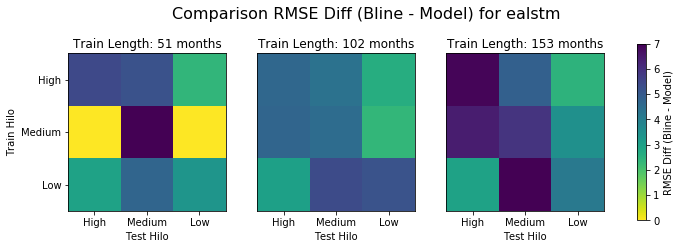

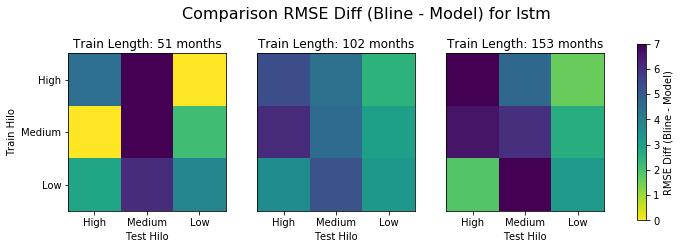

In [74]:
model = 'ealstm'
kwargs = dict(vmin=0, vmax=7, cmap='viridis_r')
plot_experiment_matrices(mean_rmse_diff_df, model, value='RMSE Diff (Bline - Model)', **kwargs)

model = 'lstm'
plot_experiment_matrices(mean_rmse_diff_df, model, value='RMSE Diff (Bline - Model)', **kwargs)

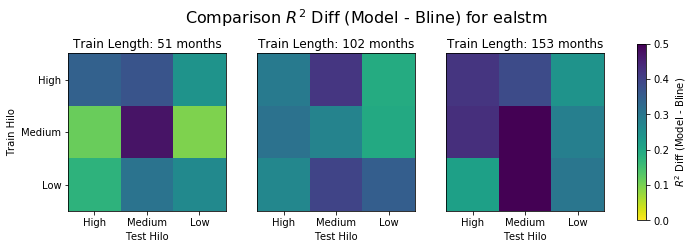

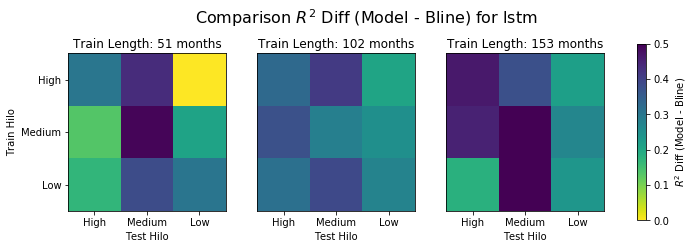

In [75]:
kwargs = dict(vmin=0, vmax=0.5, cmap='viridis_r')
model = 'ealstm'
plot_experiment_matrices(mean_r2_diff_df, model, value='$R^2$ Diff (Model - Bline)', **kwargs)

model = 'lstm'
plot_experiment_matrices(mean_r2_diff_df, model, value='$R^2$ Diff (Model - Bline)', **kwargs)

## Interpretation
* We seem to perform best (RMSE) on the LOW test period VCI values (i.e. in drought conditions)
* it looks like these are the easiest conditions to predict anyway (the baseline performance is best on these models -> persistence of poor vegetation health conditions)
* Our performance does improve as the training period gets longer

## As we increase training length do our models get better?
yes! a clear signal

In [76]:
type(ax)
# plt.axes #subplots.AxesSubplot

matplotlib.axes._subplots.AxesSubplot

In [77]:
def barplot_train_lengths(df: pd.DataFrame, 
                          y_var: str = 'RMSE', 
                          model: str = 'ealstm',
                          ylim: List[int] = [0, 25],
                          title: Optional[str] = None
                         ) -> plt.Axes:
    assert y_var in [c for c in df.columns]
    
    if model is not "BOTH":
        query = f'model == "{model}_pred"'
    else:
        query = f'model == "lstm_pred" | model == "ealstm_pred"'

    ax = sns.barplot(
        x='test_hilo', hue='train_length', y='RMSE', 
        data=df.query(query)
    )
    
    ax.set_ylim(ylim)
    if title is None:
        title = f'{model.upper()}'
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

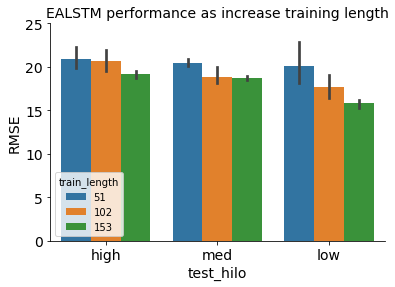

In [78]:
# ------------ EALSTM ------------ #
model = 'ealstm'
title = f'{model.upper()} performance as increase training length'
barplot_train_lengths(
    df=mean_rmse_df, y_var='RMSE', 
    model=model, ylim=[0, 25],title=title
)

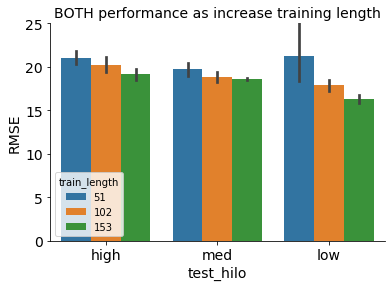

In [79]:
# ------------ EALSTM ------------ #
model = 'BOTH'
title = f'{model.upper()} performance as increase training length'
barplot_train_lengths(
    df=mean_rmse_df, y_var='RMSE', 
    model=model, ylim=[0, 25],title=title
)

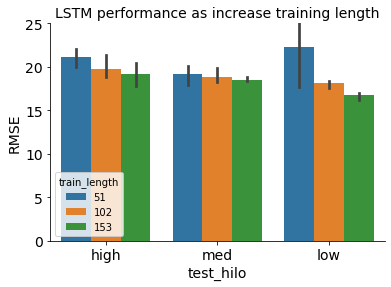

In [80]:
# ------------ LSTM ------------ #
model = 'lstm'
title = f'{model.upper()} performance as increase training length'
barplot_train_lengths(
    df=mean_rmse_df, y_var='RMSE', 
    model=model, ylim=[0, 25],title=title
)

#### Difference from persistence?
**NOTE**: Higher bars are now better

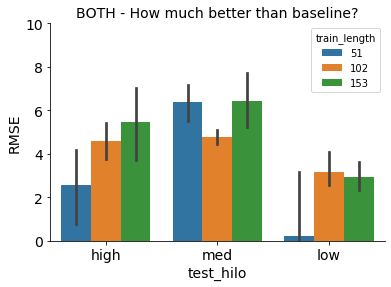

In [81]:
model = 'BOTH'
title = f'{model.upper()} - How much better than baseline?'
ylim = [0, 10]
barplot_train_lengths(
    df=mean_rmse_diff_df, y_var='RMSE', 
    model=model, ylim=ylim,title=title
)

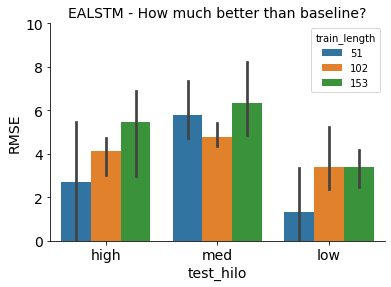

In [82]:
# ------------ EALSTM ------------ #
model = 'ealstm'
title = f'{model.upper()} - How much better than baseline?'
ylim = [0, 10]
barplot_train_lengths(
    df=mean_rmse_diff_df, y_var='RMSE', 
    model=model, ylim=ylim,title=title
)

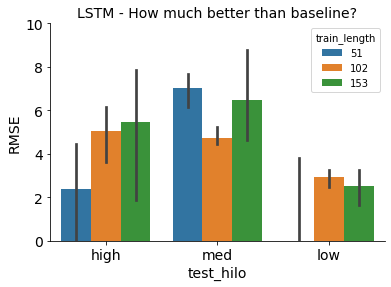

In [83]:
# ------------ LSTM ------------ #
model = 'lstm'
title = f'{model.upper()} - How much better than baseline?'
ylim = [0, 10]
barplot_train_lengths(
    df=mean_rmse_diff_df, y_var='RMSE', 
    model=model, ylim=ylim,title=title
)

## As we test / train in the same regime do our models improve?
Yes but only just / a little

In [84]:
mean_rmse_df.head()

,experiment,model,test_hilo,train_hilo,train_length,RMSE
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,21.431805
1,one_month_forecast_TRhigh_TEhigh_LEN51,bline_pred,high,high,51,25.865590
2,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,20.413579
3,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,18.856507
4,one_month_forecast_TRhigh_TEhigh_LEN102,bline_pred,high,high,102,24.182788


In [85]:
def barplot_train_test_regime(df: pd.DataFrame, 
                              y_var: str = 'RMSE', 
                              model: str = 'ealstm',
                              ylim: List[int] = [0, 25],
                              title: Optional[str] = None
                             ) -> plt.Axes:
    assert y_var in [c for c in df.columns]
    
    if model is not "BOTH":
        query = f'model == "{model}_pred"'
    else:
        query = f'model == "lstm_pred" | model == "ealstm_pred"'

    ax = sns.barplot(
        x='test_hilo', hue='train_hilo', y='RMSE', 
        data=df.query(query)
    )
    
    ax.set_ylim(ylim)
    if title is None:
        title = f'{model.upper()}'
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

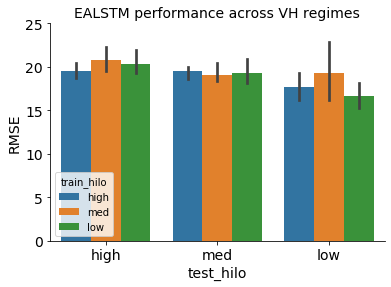

In [86]:
model = 'ealstm'
title = f'{model.upper()} performance across VH regimes'
ylim = [0, 25]
barplot_train_test_regime(
    df=mean_rmse_df, y_var='RMSE', 
    model=model, ylim=ylim, title=title
)

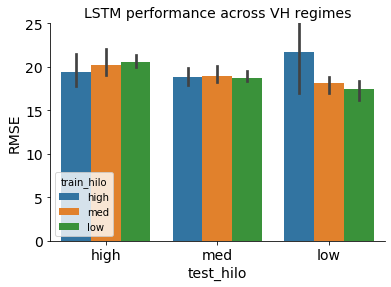

In [87]:
model = 'lstm'
title = f'{model.upper()} performance across VH regimes'
ylim = [0, 25]
barplot_train_test_regime(
    df=mean_rmse_df, y_var='RMSE', 
    model=model, ylim=ylim, title=title
)

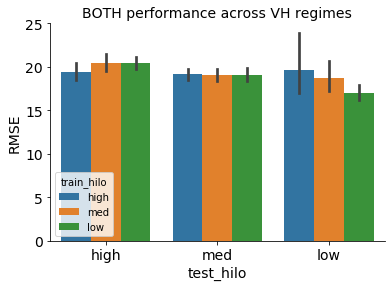

In [88]:
model = 'BOTH'
title = f'{model.upper()} performance across VH regimes'
ylim = [0, 25]
barplot_train_test_regime(
    df=mean_rmse_df, y_var='RMSE', 
    model=model, ylim=ylim, title=title
)

### Difference from persistence?
NOTE: Higher bars are now better!

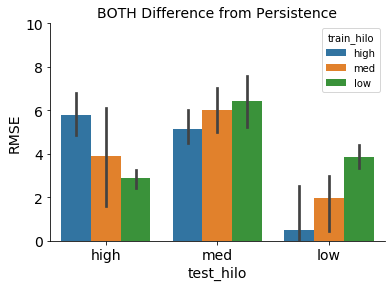

In [89]:
model = 'BOTH'
title = f'{model.upper()} Difference from Persistence'
ylim = [0, 10]
barplot_train_test_regime(
    df=mean_rmse_diff_df, y_var='RMSE', 
    model=model, ylim=ylim, title=title
)

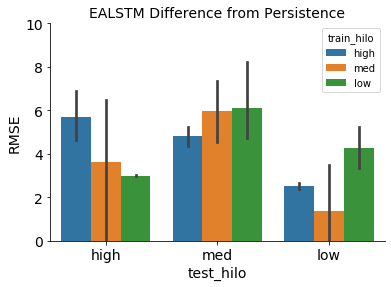

In [90]:
model = 'ealstm'
title = f'{model.upper()} Difference from Persistence'
ylim = [0, 10]
barplot_train_test_regime(
    df=mean_rmse_diff_df, y_var='RMSE', 
    model=model, ylim=ylim, title=title
)

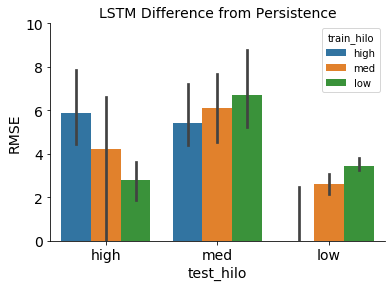

In [91]:
model = 'lstm'
title = f'{model.upper()} Difference from Persistence'
ylim = [0, 10]
barplot_train_test_regime(
    df=mean_rmse_diff_df, y_var='RMSE', 
    model=model, ylim=ylim, title=title
)

# What about a matrix of barplots?

### High Level Overview
* low, med, high train lengths
* 3x3 matrices of (test_hilo vs. train_hilo) 
* expect to see better performance on the 1:1 line

,experiment,model,test_hilo,train_hilo,train_length,RMSE
0,one_month_forecast_TRhigh_TEhigh_LEN51,lstm_pred,high,high,51,4.433786
1,one_month_forecast_TRhigh_TEhigh_LEN51,ealstm_pred,high,high,51,5.452012
2,one_month_forecast_TRhigh_TEhigh_LEN102,lstm_pred,high,high,102,5.326281
3,one_month_forecast_TRhigh_TEhigh_LEN102,ealstm_pred,high,high,102,4.651533
4,one_month_forecast_TRhigh_TEhigh_LEN153,lstm_pred,high,high,153,7.841748


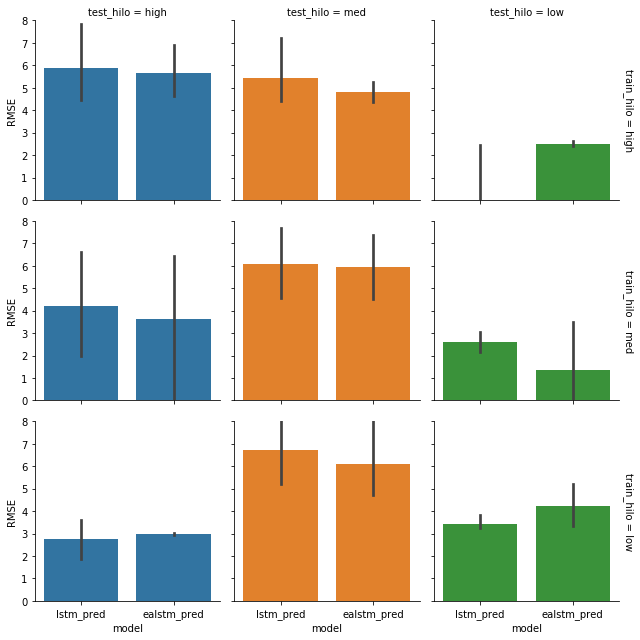

In [92]:
plot_df = mean_rmse_diff_df.query(" model == 'ealstm_pred' | model == 'lstm_pred' ")
display(plot_df.head())

g = sns.FacetGrid(plot_df, row="train_hilo", col="test_hilo", margin_titles=True, hue='test_hilo', ylim=[0, 8])
axs = g.map(sns.barplot, 'model', 'RMSE')
# axs = g.map(sns.factorplot, 'model', 'RMSE')
# [ax.set_ylim([0, 8]) for ax in g.axes.flatten()];

# Let's look at the distributions of the driving datasets
- How similar are the train/test periods for each regime (should be most different for the low experiments)

In [93]:
from scripts.experiments.experiment import make_monthly_calendar_plot

In [106]:
EXPT_IX = 7

train_low = []
train_high = []
train_med = []

expt = [expt for expt in obs_dict.keys()][EXPT_IX]
train_hilo = expt.split('_')[-3][2:]
test_hilo = expt.split('_')[-2][2:]
train_length = int(expt.split('_')[-1][3:])
if train_hilo == "low":
    pass
if train_hilo == "med":
    pass
if train_hilo == "high":
    pass

print(f"* train_hilo: {train_hilo}")
print(f"* test_hilo:  {test_hilo}")
print(f"* train_length:  {train_length}")
print('\n')

obs_dict[expt]['X_train']

* train_hilo: high
* test_hilo:  low
* train_length:  102




<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 143)
Coordinates:
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * time        (time) datetime64[ns] 2002-03-31 2002-04-30 ... 2018-11-30
Data variables:
    VCI3M       (time, lat, lon) float64 29.06 26.52 19.64 59.9 ... nan nan nan
    boku_VCI    (time, lat, lon) float64 50.0 34.07 23.6 44.72 ... nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.216 0.1968 0.2064 ... nan nan nan
    VCI         (time, lat, lon) float64 21.34 36.43 22.51 30.84 ... nan nan nan
    precip      (time, lat, lon) float64 71.85 66.19 64.85 82.17 ... nan nan nan
    E           (time, lat, lon) float64 43.59 44.53 44.53 55.29 ... nan nan nan
    Eb          (time, lat, lon) float64 8.092 6.271 6.271 5.636 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2649 0.2726 0.2726 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2925 0.2976 0.2976 ... nan nan nan
    p84.162     (time, lat, lon) float64 -2.285e-05 1.452e-05 ... 2.575e-05
    pev         (time, lat, lon) float64 -0.007094 -0.006964 ... -2.328e-09
    sp          (time, lat, lon) float64 9.58e+04 9.593e+04 ... 1.012e+05
    t2m         (time, lat, lon) float64 303.5 303.6 302.2 ... 300.2 300.2 300.2
    tp          (time, lat, lon) float64 0.002777 0.002 ... 0.001626 0.001602

In [134]:
def prepare_mean_dataframe(da: xr.DataArray,
                           variable: str,
                           first_year: str = 2001,
                           last_year: str = 2018,
) -> pd.DataFrame:
    
    # calculate SPATIAL MEAN (changing over time)
    df = (
        da.mean(dim=['lat', 'lon'])
        .to_dataframe()
        .reset_index()
        .astype({variable: float})
    )

    df = df.drop_duplicates().set_index('time')

    # add in the FIRST month
    _df = pd.DataFrame(
        {variable: [np.nan]},  # , 'year':[np.nan], 'month':[np.nan]
        index=[pd.to_datetime(f'{first_year}-12-30')]
    )
    df = pd.concat([_df, df])
    # add in the LAST month
    _df = pd.DataFrame(
        {variable: [np.nan]}, 
        index=[pd.to_datetime(f'{last_year}-12-30')]
    )
    df = pd.concat([_df, df])
    
    # ensure all timesteps included (even if np.nan)
    df = df.resample('M').first()

    # assign month/year
    df['month'] = [pd.to_datetime(d).month for d in df.index]
    df['year'] = [pd.to_datetime(d).year for d in df.index]

    # nullable integer type 
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html
    # df = df.astype({'year': pd.Int64Dtype()})
    
    return df


# data = 'X_train'
data = 'X_test'
variable = 'precip'

# data = 'y_train'
# data = 'y_test'
# variable = 'boku_VCI'

,precip,month,year
2001-12-31,NaN,12,2001
2002-01-31,NaN,1,2002
2002-02-28,NaN,2,2002
2002-03-31,NaN,3,2002
2002-04-30,NaN,4,2002


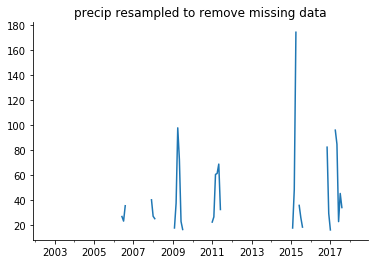

In [135]:
precip_df = prepare_mean_dataframe(
    da=obs_dict[expt][data][variable],
    variable=variable
)
display(precip_df.head())

# look at the missing data! <3
fig, ax = plt.subplots()
precip_df[variable].plot(ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'{variable} resampled to remove missing data');

In [159]:
print(expt)
highlight_timesteps = [
    pd.to_datetime(dt) 
    for dt in obs_dict[expt]['y_test'].time.values
]
x_var_kwargs = dict(vmin=0, vmax=120)
y_var_kwargs = dict(vmin=0, vmax=100)


def plot_experiment_X_y_matrices(
    expt: str, x_var: str, highlight_timesteps: List[pd.Timestamp], y_var: str = 'boku_VCI',
    x_var_kwargs: Optional[Dict] = None, y_var_kwargs: Optional[Dict] = None
):
    """"""
    assert False, "THis function does not work!"
    df_dict = {}
    
    for data in ['X_train', 'X_test']:  # 'y_train', 'y_test'
        df_dict[data] = prepare_mean_dataframe(
            da=obs_dict[expt][data][x_var],
            variable=x_var
        )
    for data in ['y_train', 'y_test']:
        df_dict[data] = prepare_mean_dataframe(
            da=obs_dict[expt][data][y_var],
            variable=y_var
        )
    
    # make 2x2 plot
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    for ax_ix, key in zip([np.unravel_index(i, (2, 2)) for i in range(4)], df_dict.keys()):
        ax = axs[ax_ix]
        if "X" in key:
            variable = x_var
            kwargs = x_var_kwargs
        elif "y" in key:
            variable = y_var
            kwargs = y_var_kwargs
        
        # calendar plot
        ax = make_monthly_calendar_plot(
            df_dict[key], 
            title=f'{key}: {variable}', 
            ax=ax, 
            highlight_timesteps=None, 
            **kwargs
        )
    
# plot_experiment_X_y_matrices(
#     expt=expt, x_var='precip', 
#     highlight_timesteps=highlight_timesteps,
#     x_var_kwargs=x_var_kwargs, y_var_kwargs=y_var_kwargs
# )

one_month_forecast_TRhigh_TElow_LEN102


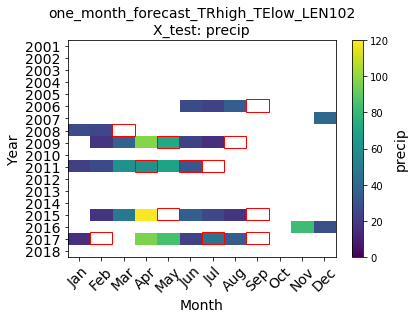

In [161]:
def plot_calendar_plot(data_df: pd.DataFrame, data: str, variable: str, highlight_timesteps: Optional[List[pd.Timestamp]]):
    fig, ax = plt.subplots()

    if variable == 'precip':
        kwargs = dict(vmin=0, vmax=120)
    if variable == 'boku_VCI':
        kwargs = dict(vmin=0, vmax=100)

    ax = make_monthly_calendar_plot(
        data_df, 
        title=f'{expt} {variable}', 
        ax=ax, 
        highlight_timesteps=highlight_timesteps, 
        **kwargs
    )
    ax.set_title(f'{expt}\n{data}: {variable}', size=14);

    plt.show()
    
data = 'X_test'
variable = 'precip'
data_df = prepare_mean_dataframe(
    da=obs_dict[expt][data][variable],
    variable=variable
)

highlight_timesteps = [
    pd.to_datetime(dt) 
    for dt in obs_dict[expt]['y_test'].time.values
]

plot_calendar_plot(data_df, data, variable, highlight_timesteps)

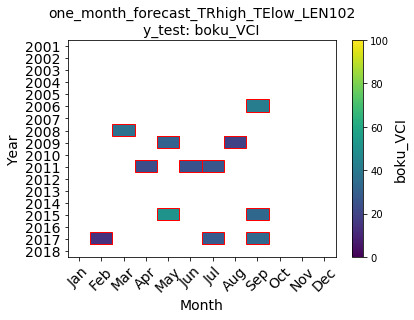

In [162]:
data = 'y_test'
variable = 'boku_VCI'
data_df = prepare_mean_dataframe(
    da=obs_dict[expt][data][variable],
    variable=variable
)
plot_calendar_plot(data_df, data, variable, highlight_timesteps)

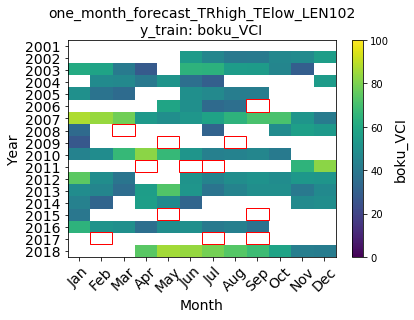

In [163]:
data = 'y_train'
variable = 'boku_VCI'
data_df = prepare_mean_dataframe(
    da=obs_dict[expt][data][variable],
    variable=variable
)
plot_calendar_plot(data_df, data, variable, highlight_timesteps)

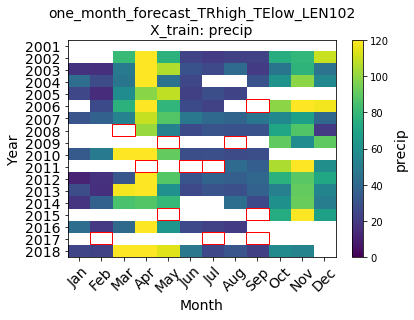

In [165]:
data = 'X_train'
variable = 'precip'
data_df = prepare_mean_dataframe(
    da=obs_dict[expt][data][variable],
    variable=variable
)
plot_calendar_plot(data_df, data, variable, highlight_timesteps)